In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import numpy as np
import math

In [2]:
def create_random_walk(n, v, w):
    """ランダムウォークの真値と観測データを生成
    
    ランダムウォークの真値とノイズ入り観測データを生成

    Args:
        n(int): 生成するデータ数
        v(float): 変動量の分散
        w(float): 観測ノイズの分散
    
    Returns:
        List[flot], List[flot]: 真値,観測データ
    """
    x = np.cumsum(np.random.normal(0.0, math.sqrt(v), n))
    y = x + np.random.normal(0.0, math.sqrt(w), n)
    return x, y

In [79]:
def predict_llm(x, x_var, y, v, w):
    """ローカルレベルモデルでの予測
    
    ローカルレベルモデルで計測値から次のデータを予測

    Args:
        x(float): 現在の予測値
        x_var(float): 現在の予測値の尤度の分散
        y(float): 新しい観測地
        v(float): 変動量の分散
        w(float): 観測ノイズの分散

    Returns:
        flot, float, float: 新しい予測値、新しい予測値の尤度の分散、尤度
    """
    
    # 現在値の予測
    predict_x     = x           # 期待値は前回の値のそのまま
    predict_x_var = x_var + v   # 分散を加算される
    
    # 尤度
    likelihood = scipy.stats.norm.pdf(y, loc=predict_x, scale=np.sqrt(predict_x_var + w))
    
    # カルマンゲインを計算
    kalman_gain = predict_x_var / (predict_x_var + w)
    
    # 計測値と合成
    next_x     = predict_x + kalman_gain * (y - predict_x)
    next_x_var = (1 - kalman_gain) * predict_x_var
    
    # 2変数の最適合成という点ではこう書いても等価のはず
#   next_x     = (w * predict_x +  predict_x_var * y) / (predict_x_var * w)
#   next_x_var = (predict_x_var * w) / (predict_x_var + w)
        
    return next_x, next_x_var, likelihood

In [80]:
# ローカルレベルモデルで計測値から予測を実施
def calc_predict(y, v, w):
    n = len(y)
    x     = np.ndarray(n)
    x_var = np.ndarray(n)
    l     = np.ndarray(n)
    x[0]     = 0
    x_var[0] = 0
    l[0]     = 1.0
    for i in range(1, n):
        x[i], x_var[i], l[i] = predict_llm(x[i-1], x_var[i-1], y[i], v, w)
    return x, x_var, l

In [81]:
# テストデータ生成(これを真値とする)
v_true = 1.0
w_true = 4.0
x_true, y = create_random_walk(1000, v_true, w_true)

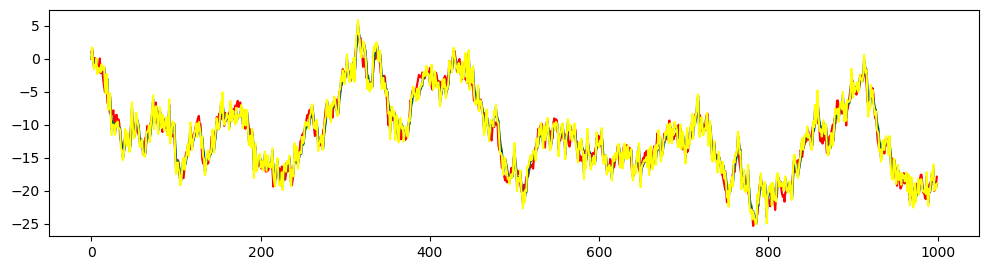

In [82]:
# 分散を変えて計算してみる
v_test = [1.0, 2.0, 3.0]
w_test = [4.0, 3.0, 2.0]
n = 3

list_x = []
list_x_var = []
list_l = []
for i in range(n):
    x, x_var, l = calc_predict(y, v_test[i], w_test[i])
    list_x.append(x)
    list_x_var.append(x_var)
    list_l.append(l)

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x_true, c='red', label='ground truth')
plt.plot(list_x[0], c='green', label='v=%f w=%f' % (v_test[0], w_test[0]))
plt.plot(list_x[1], c='blue', label='v=%f w=%f' % (v_test[1], w_test[1]))
plt.plot(list_x[2], c='yellow', label='v=%f w=%f' % (v_test[2], w_test[2]))


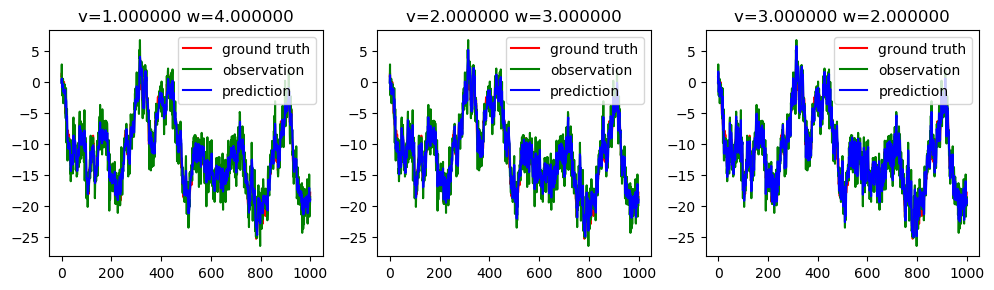

In [83]:
fig = plt.figure(figsize=(12, 3), dpi=100)
for i in range(n):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('v=%f w=%f' % (v_test[i], w_test[i]))
    ax.plot(x_true, c='red', label='ground truth')
    ax.plot(y, c='green', label='observation')
    ax.plot(list_x[i], c='blue', label='prediction')
    ax.legend()

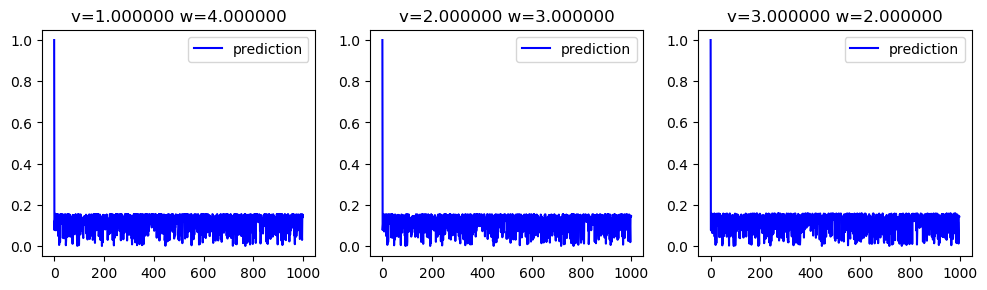

In [84]:
fig = plt.figure(figsize=(12, 3), dpi=100)
for i in range(n):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('v=%f w=%f' % (v_test[i], w_test[i]))
    ax.plot(list_l[i], c='blue', label='prediction')
    ax.legend()

In [85]:
# 分散をデータから予測する
# のを今度やってみよう

In [86]:
def minimize_func(x):
    x, x_var, l = calc_predict(y, np.exp(x[0]), np.exp(x[1]))
    return -np.sum(np.log(l))

In [95]:
result = scipy.optimize.minimize(minimize_func, x0=[1.0, 1.0], method="SLSQP")

c:\users\ryuji2\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
print(result)
print(np.exp(result.x))

     fun: 2350.6927439235114
     jac: array([ 0.00097656, -0.00250244])
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([-0.04696281,  1.38462908])
[0.95412288 3.99334443]


In [92]:
minimize_func([np.log(1.0), np.log(5.0)])

2359.147866326747

In [93]:
minimize_func([np.log(1.0), np.log(4.0)])

2350.767554646388

In [94]:
minimize_func([np.log(1.0), np.log(3.0)])

2363.7650314264997